#  **Практическое занятие №5. Введение в нейронные сети.**

## Знакомство с **PyTorch**
See https://pytorch.org/tutorials

In [727]:
import torch
import numpy as np
import matplotlib.pyplot as plt

### Tensors

Массивы в PyTorch

See https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html

In [728]:
# simple creation
t = torch.tensor([[1, 2], [3, 4]])
t

tensor([[1, 2],
        [3, 4]])

In [729]:
# to numpy
n = t.numpy()
n

array([[1, 2],
       [3, 4]], dtype=int64)

In [730]:
# from numpy
t = torch.from_numpy(n)
t

tensor([[1, 2],
        [3, 4]])

In [731]:
# tensors and ndarrays share memory
t = torch.arange(5)
n = t.numpy()

n[0] = 100

t

tensor([100,   1,   2,   3,   4])

### Autograd

Автоматическое дифференцирование

See https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html

In [732]:
# manual gradient for mse loss in linear regression
def grad(w, X, y):
    return (2 * X.T @ (X @ w - y)) / len(X)


X = np.random.rand(5, 2)
y = np.random.rand(5)
w = np.array([1., 2.])

grad(w, X, y)

array([0.92210921, 1.46385424])

In [733]:
# torch gradient
X = torch.from_numpy(X).to(dtype=torch.float)
y = torch.from_numpy(y).to(dtype=torch.float)
w = torch.tensor([1., 2.], requires_grad=True)

l = torch.nn.functional.mse_loss(X @ w, y)
l.backward()

w.grad

tensor([0.9221, 1.4639])

### Datasets and Dataloaders

See https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

#### MNIST dataset

See https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST

In [734]:
from torchvision import datasets

mnist = datasets.MNIST(root='mnist', download=True)

mnist

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist
    Split: Train

In [735]:
mnist[10]

(<PIL.Image.Image image mode=L size=28x28>, 3)

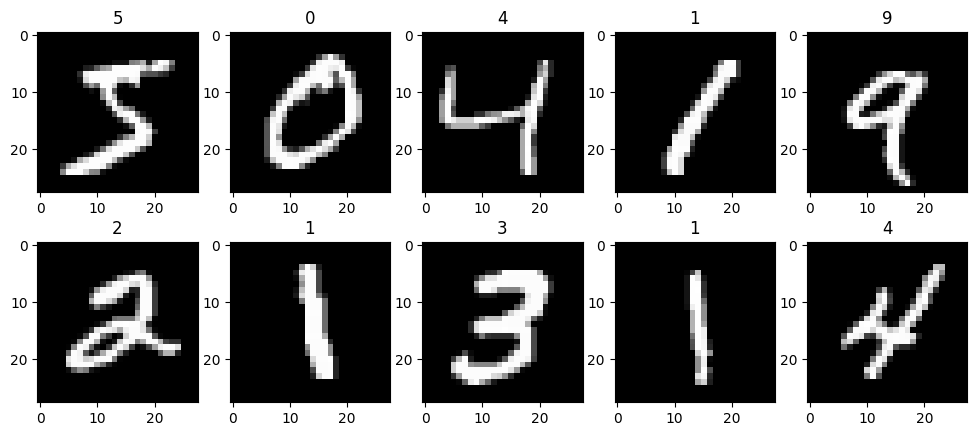

In [736]:
plt.figure(figsize=(12, 5))

for i in range(10):
    x, y = mnist[i]
    plt.subplot(2, 5, i + 1)
    plt.title(f'{y}')
    plt.imshow(x, cmap='gray')

plt.show()

#### Custom dataset

In [737]:
from torch.utils.data import Dataset


class RandomDataset(Dataset):
    def __init__(self, n_objects, n_features):
        # your code here
        self.X = torch.rand(n_objects, n_features)
        self.y = torch.rand(n_objects)

    def __len__(self):
        # your code here
        return len(self.X)

    def __getitem__(self, idx):
        # your code here
        return self.X[idx], self.y[idx]

In [738]:
data = RandomDataset(100, 5)

x, y = data[0]

print(f'x = {x}')
print(f'y = {y}')

x = tensor([0.9546, 0.7328, 0.1387, 0.0755, 0.9378])
y = 0.24291646480560303


#### Dataloader

In [739]:
from torch.utils.data import DataLoader

dataloader = DataLoader(data, batch_size=50, shuffle=True)

for i, (X, y) in enumerate(dataloader):
    print(f'Batch {i}')
    print(f'X.shape = {X.shape}')
    print(f'y.shape = {y.shape}')

Batch 0
X.shape = torch.Size([50, 5])
y.shape = torch.Size([50])
Batch 1
X.shape = torch.Size([50, 5])
y.shape = torch.Size([50])


### Neural Networks

#### Генерируем датасет

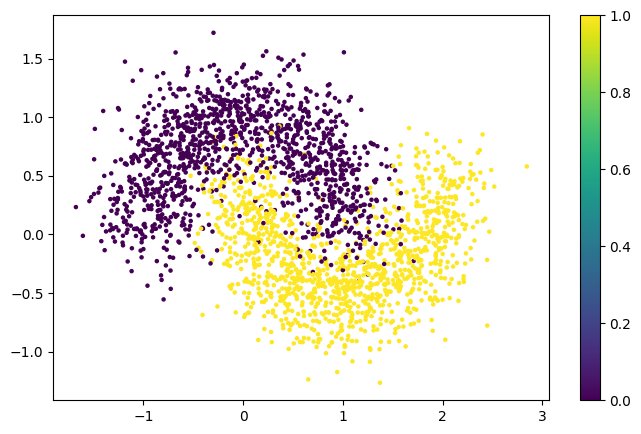

In [740]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

X, y = make_moons(10000, noise=0.25, random_state=12)

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train = torch.from_numpy(X_train).to(dtype=torch.float)
y_train = torch.from_numpy(y_train).to(dtype=torch.float)
X_test = torch.from_numpy(X_test).to(dtype=torch.float)
y_test = torch.from_numpy(y_test).to(dtype=torch.float)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

plt.figure(figsize=(8, 5))

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=5)
plt.colorbar()

plt.show()

**Вопрос:** Почему нам не хватит линейной модели для решения задачи?

#### Собираем модель

See https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html \
See https://pytorch.org/docs/stable/nn.html

In [741]:
from torch import nn

# your code here
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=1),
    nn.Sigmoid(),
    nn.Flatten(start_dim=0)
)

model

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
  (5): Sigmoid()
  (6): Flatten(start_dim=0, end_dim=-1)
)

In [742]:
# model should predict in [0,1)
with torch.no_grad():
    x, y = train_dataset[0]
    print(f'x = {x}')
    print(f'y_true = {y}')
    print(f'y_pred = {model(x).item()}')

x = tensor([0.6155, 0.7862])
y_true = 0.0
y_pred = 0.38282960653305054


**Вопрос:** Сколько всего параметров в модели? Почему столько?

In [743]:
# check model parameters
params_count = 0
for param in model.parameters():
    params_count += torch.numel(param)
params_count

151

#### Обучаем модель

See https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

##### Выбираем лосс функцию
See https://pytorch.org/docs/stable/nn.html#loss-functions

In [744]:
# your code here
loss_function = nn.BCELoss()

##### Выбираем оптимизатор

In [745]:
from torch import optim

# your code here
optimizer = optim.SGD(model.parameters(), lr=1e-1)

##### Запускаем тренировочный цикл

In [746]:
def run(model, dataloader, loss_function, optimizer=None):
    # set the model to evaluation or training mode
    if optimizer == None:
        model.eval()
    else:
        model.train()

    total_loss = 0

    for X, y in dataloader:
        # compute prediction
        pred = model(X)
        # compute loss
        loss = loss_function(pred, y)
        # save loss
        total_loss += loss.item()
        if optimizer != None:
            # compute gradients
            loss.backward()
            # do optimizer step
            optimizer.step()
            # clear gradients
            optimizer.zero_grad()

    return total_loss / len(dataloader)

In [747]:
from IPython.display import clear_output


def show_losses(train_loss_hist, test_loss_hist):
    clear_output()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.title('Train Loss')
    plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title('Test Loss')
    plt.plot(np.arange(len(test_loss_hist)), test_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.show()

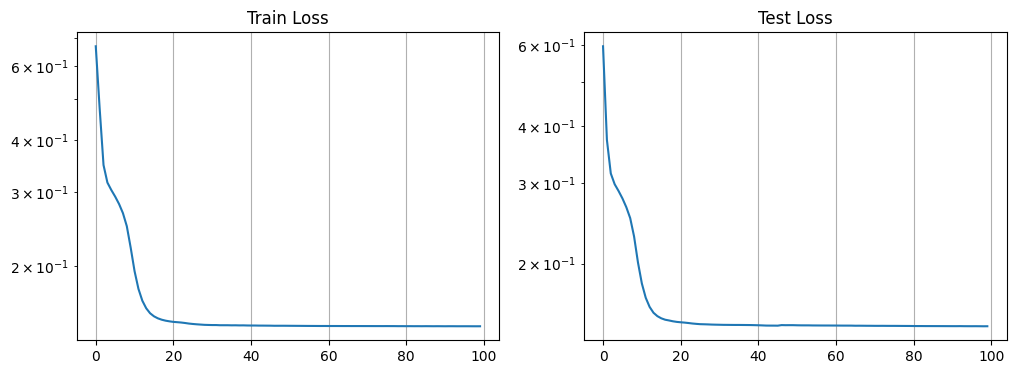

In [748]:
BATCH_SIZE = 100
NUM_EPOCHS = 100

# your code here
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

train_loss_hist = []
test_loss_hist = []

for i in range(NUM_EPOCHS):
    train_loss = run(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)
    test_loss = run(model, test_loader, loss_function)
    test_loss_hist.append(test_loss)

    if i % 10 == 9:
        show_losses(train_loss_hist, test_loss_hist)

#### Смотрим результаты

In [749]:
def make_levels(x_grid, y_grid, func, num_levels=10):
    X, Y = torch.meshgrid(x_grid, y_grid)
    Z = torch.empty_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func(torch.tensor([X[i, j], Y[i, j]]))
    levels = torch.linspace(torch.min(Z), torch.max(Z), steps=num_levels)
    return X, Y, Z, levels

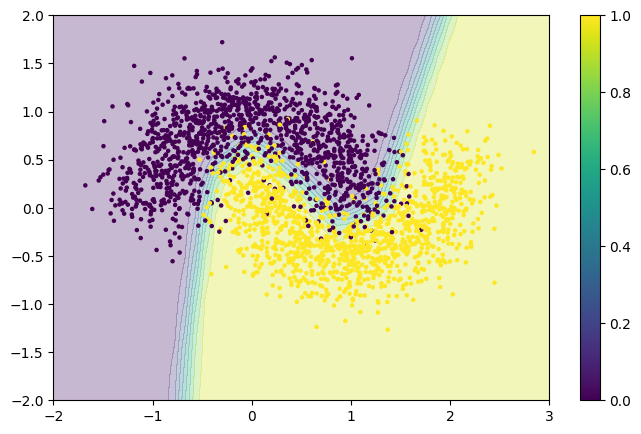

In [750]:
model.eval()

plt.figure(figsize=(8, 5))

levels = make_levels(torch.linspace(-2, 3, 50), torch.linspace(-2, 2, 50), lambda x: model(x).item())

plt.contourf(*levels, alpha=0.3)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=5)
plt.colorbar()

plt.show()

## Дополнительные замечания

### MNIST - многоклассовая классификация

Возможно, пригодится *one-hot encoding*

See https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html

Лосс-функция `BCELoss` не подойдет, стоит поискать подходящую

See https://pytorch.org/docs/stable/nn.html#loss-functions

### Объекты MNIST - картинки (PIL.Image)

Стоит обратить внимание на параметр transform датасета MNIST - с его помощью сразу преобразовать объекты выборки

See https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST \
See https://pytorch.org/vision/master/generated/torchvision.transforms.ToTensor.html

Объекты MNIST двумерные, стоит это учесть при разработке архитектуры модели

See https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html

### Борба с переобучением

Возможно, пригодятся модули `nn.Dropout` и `nn.BatchNorm`

See https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html \
See https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html

Импортнем все, что нужно

In [751]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Напишем преобразователь для данных MNIST

In [752]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

Чтобы не прыгать со страницы с кодом на другую, соберем данные снова

In [753]:
train_dataset = datasets.MNIST(root='./mnist', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root='./mnist', train=False, download=False, transform=transform)

Пропишем данные модели: картинки 28 на 28 пикселей, то есть 28*28 факторов (яркость пикселей - черно-белая картинка же), 10 чисел всего - 10 итогов.

Оптимальный скрытый слой определим в процессе экспериментов

In [754]:
input_size = 28 * 28

Соберем модель, которую будем менять для нахождения лучших метрик

In [755]:
model = nn.Sequential(
    nn.Flatten(),              
    nn.Linear(input_size, 256), 
    nn.ReLU(),                
    nn.Linear(256, 128),      
    nn.ReLU(), 
    nn.Linear(128, 32),      
    nn.ReLU(),
    nn.BatchNorm1d(32),        
    nn.Dropout(0.5),           
    nn.Linear(32, 10),
    nn.LogSoftmax(dim=1),
)

model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=32, bias=True)
  (6): ReLU()
  (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=32, out_features=10, bias=True)
  (10): LogSoftmax(dim=1)
)

Выглядит зачетно, выглядит олрайт

Выберем функцию лосса

In [756]:
loss_function = nn.CrossEntropyLoss()

Выберем оптимизатор - хз вроде норм, да и метрики хорошие

In [757]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Подкинем параметры обучения, потом еще определим оптимальные

In [758]:
batch_size = 32
num_epochs = 90

train_loss_hist = []
validation_loss_hist = []
best_validation_loss = float('inf')

DataLoader для обучающей, валидационной и тестовой выборок

In [759]:
validation_fraction = 0.2  
num_train_samples = len(train_dataset)
num_validation_samples = int(validation_fraction * num_train_samples)

train_subset, validation_subset = random_split(train_dataset, [num_train_samples - num_validation_samples, num_validation_samples])

In [760]:
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_subset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Солнце еще высоко, модель должна учится

In [761]:
def run(model, dataloader, loss_function, optimizer=None):
    if optimizer is not None:
        model.train()
    else:
        model.eval()

    total_loss = 0
    all_predictions = []
    all_labels = []

    for X, y in dataloader:
        pred = model(X.view(X.size(0), -1))
        loss = loss_function(pred, y)
        total_loss += loss.item()

        if optimizer is not None:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        _, predicted = torch.max(pred, 1)
        all_predictions.extend(predicted.tolist())
        all_labels.extend(y.tolist())

    avg_loss = total_loss / len(dataloader)
    return avg_loss, all_predictions, all_labels

Модель на валидационной выборке

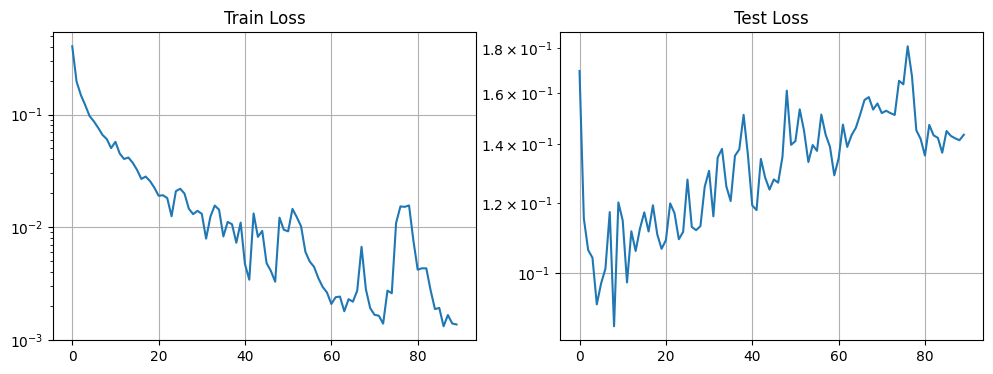

In [762]:
for epoch in range(num_epochs):
    train_loss, _, _ = run(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)
    validation_loss, predictions, true_labels = run(model, validation_loader, loss_function)
    validation_loss_hist.append(validation_loss)
    
    best_validation_loss = min(best_validation_loss, validation_loss)

    if (epoch + 1) % 1 == 0:
        show_losses(train_loss_hist, validation_loss_hist)

In [763]:
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')


print(f'Best validation loss: {best_validation_loss:.4f}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

Best validation loss: 0.0870
Accuracy: 0.9843333333333333
Precision: 0.9842179714210815
Recall: 0.9842261864770723
F1-score: 0.9842101763505446


Модель на тестовой выборке

In [764]:
_, predictions, true_labels = run(model, test_loader, loss_function)

Ну-ка посмотрим что ты можешь

In [765]:
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')

In [766]:
print(f'Best validation loss: {best_validation_loss:.4f}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

Best validation loss: 0.0870
Accuracy: 0.9824
Precision: 0.982278042009653
Recall: 0.9822987569424887
F1-score: 0.9822825051387598


| Номер | model | Loss Function    | Activation Function | Optimizer       | Epochs | Batch Size | Accuracy | Precision | Recall | F1-score | Minimum loss |
|-------|-------|------------------|---------------------|-----------------|--------|------------|----------|-----------|--------|----------|--------------|
| 1     | 2     | CrossEntropyLoss | Relu                | SGD(0.01, 0.5)  | 40     | 64         | 0.9792   | 0.9791    | 0.9790 | 0.9790   | 0.0681       |
| 2     | 1     | CrossEntropyLoss | Relu                | SGD(0.001, 0.9) | 40     | 64         | 0.9776   | 0.9775    | 0.9773 | 0.9774   | 0.0747       |
| 3     | 1     | CrossEntropyLoss | Relu                | Adam            | 40     | 64         | 0.9805   | 0.9805    | 0.9806 | 0.9807   | 0.0693       |
| 4     | 1     | CrossEntropyLoss | Relu                | Adam            | 30     | 64         | 0.9769   | 0.9769    | 0.9766 | 0.9767   | 0.0673       |
| 5     | 1     | CrossEntropyLoss | Relu                | Adam            | 10     | 64         | 0.9755   | 0.9754    | 0.9753 | 0.9753   | 0.077        |
| 6     | 3     | CrossEntropyLoss | Relu                | SGD(0.01, 0.5)  | 40     | 64         | 0.9807   | 0.9805    | 0.9805 | 0.9805   | 0.0666       |
| 7     | 4     | CrossEntropyLoss | Relu                | SGD(0.01, 0.9)  | 40     | 64         | 0.984    | 0.9838    | 0.9837 | 0.9838   | 0.0699       |
| 8     | 4     | CrossEntropyLoss | Relu                | SGD(0.01, 0.9)  | 90     | 64         | 0.9824   | 0.9823    | 0.9823 | 0.9823   | 0.0870       |


model 1.0
model = nn.Sequential(
    nn.Flatten(),          
    nn.Linear(input_size, 128), 
    nn.ReLU(),                        
    nn.BatchNorm1d(64),     
    nn.Dropout(0.5),          
    nn.Linear(128, 10)          
)


model 2.0
model = nn.Sequential(
    nn.Flatten(),            
    nn.Linear(input_size, 128),  
    nn.ReLU(),                
    nn.Linear(128, 64),       
    nn.ReLU(),              
    nn.BatchNorm1d(64),       
    nn.Dropout(0.5),          
    nn.Linear(64, 10)          
)

model 3.0
model = nn.Sequential(
    nn.Flatten(),              
    nn.Linear(input_size, 128), 
    nn.ReLU(),                
    nn.Linear(128, 64),      
    nn.ReLU(),                
    nn.BatchNorm1d(64),        
    nn.Dropout(0.5),           
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1),
)

model 4.0
model = nn.Sequential(
    nn.Flatten(),              
    nn.Linear(input_size, 256), 
    nn.ReLU(),                
    nn.Linear(256, 128),      
    nn.ReLU(), 
    nn.Linear(128, 32),      
    nn.ReLU(),
    nn.BatchNorm1d(32),        
    nn.Dropout(0.5),           
    nn.Linear(32, 10),
    nn.LogSoftmax(dim=1),
)

Оптимальной показала себя версия модели 4 (эксперимент 8 - она и запущена в тетрадке): выбор функции активации в целом понятен, именно такая конфигурация слоев модели показала себя лучше всего.

Она получилась после комплексного анализа задачи, а также рассмотрения схожих задач на kaggle и у 3blue1brown. CrossEntropyLoss() - по сути, единственный нормальный вариант нахождения лосса, без танцев с бубном. Оптимизатор остался из примера с урока, так как в среднем показал себя лучше, чем adam.
Большее количество слоев сети, что логично, улучшило метрики модели, применение дропаута помогло избежать переобучения. logsoftmax - дает лучший вывод предсказания - вероятности, log для вычислительной стабильности.

Понимаю, что сеть не идеальна, очень хотелось бы получить комментарии по улучшению качества модели.